## iPyLeaflet
[ipyleaflet](https://github.com/ellisonbg/ipyleaflet) is a bridge between jupyter notebooks and the [leaflet](http://leafletjs.com/)  javascript library for drawing maps.

ipyleaflet comes with a few examples notebooks (this notebook was derived from one) but very little documentation,
for more documentation read the [Leaflet IPA](http://leafletjs.com/reference.html)

For installation directions, see the README on [ipyleaflet](https://github.com/ellisonbg/ipyleaflet)

In [4]:
from ipyleaflet import (
    Map,
    Marker,
    TileLayer, ImageOverlay,
    Polyline, Polygon, Rectangle, Circle, CircleMarker,
    GeoJSON,
    DrawControl
)

## Visualizing the distribution of the observations

## Load the required libraries

In [5]:
import pandas as pd
import numpy as np
import sklearn as sk
import urllib
import math

In [6]:
import findspark
findspark.init()

from pyspark import SparkContext
#sc.stop()
sc = SparkContext(master="local[3]",pyFiles=['lib/numpy_pack.py','lib/computeStats.py'])

from pyspark import SparkContext
from pyspark.sql import *
sqlContext = SQLContext(sc)

In [7]:
import sys
sys.path.append('./lib')

import numpy as np
from numpy_pack import packArray,unpackArray
from computeStats import computeOverAllDist, STAT_Descriptions

In [8]:
### Read the data frame from pickle file

data_dir='../../Data/Weather'
file_index='SBBBBBSB'
meas='SNWD'

from pickle import load

#read statistics
filename=data_dir+'/STAT_%s.pickle'%file_index
STAT,STAT_Descriptions = load(open(filename,'rb'))
print('keys from STAT=',STAT.keys())

#!ls -ld $data_dir/*.parquet

#read data
filename=data_dir+'/decon_%s_%s.parquet'%(file_index,meas)

df=sqlContext.read.parquet(filename)
print(df.count())
df.show(2)

('keys from STAT=', ['TMIN', 'TOBS', 'TMAX', 'SNOW', 'SNWD', 'PRCP'])
798
+------------------+------------------+------------------+---------+--------+--------+---------+-----------+-------------------+-------------------+-------------------+-------------------+-----------+-----------+------+--------------------+------+
|           coeff_1|           coeff_2|           coeff_3|elevation|   label|latitude|longitude|measurement|              res_1|              res_2|              res_3|           res_mean|    station|  total_var|undefs|              vector|  year|
+------------------+------------------+------------------+---------+--------+--------+---------+-----------+-------------------+-------------------+-------------------+-------------------+-----------+-----------+------+--------------------+------+
|1811.1595024675585| 460.5274358673977|343.37546092363647|    493.5|SBBBBBSB| 48.8217|-100.4525|       SNWD|0.21585999994825414|0.16516195320429514|0.13697690891565667|0.322776483888

In [9]:
#extract longitude and latitude for each station
feature='coeff_1'
sqlContext.registerDataFrameAsTable(df,'weather')
Query="SELECT station, latitude,longitude,elevation,coeff_1,coeff_2,coeff_3 FROM weather"
print(Query)
df1 = sqlContext.sql(Query)
df1.show(4)

SELECT station, latitude,longitude,elevation,coeff_1,coeff_2,coeff_3 FROM weather
+-----------+--------+---------+---------+------------------+------------------+-------------------+
|    station|latitude|longitude|elevation|           coeff_1|           coeff_2|            coeff_3|
+-----------+--------+---------+---------+------------------+------------------+-------------------+
|USC00320941| 48.8217|-100.4525|    493.5|1811.1595024675585| 460.5274358673977| 343.37546092363647|
|USC00320941| 48.8217|-100.4525|    493.5|1268.4661434676486|273.33980279791996| -498.3505019652992|
|CA005010191|    49.3|   -99.45|    482.0| 4643.483342061809|1343.2179035744157|-1106.3804030213837|
|CA005010640|   49.55|   -99.08|    374.0| 2533.331802740035| 96.44065865069248|  514.1959210470634|
+-----------+--------+---------+---------+------------------+------------------+-------------------+
only showing top 4 rows



In [10]:
l = df1.sort(df1.longitude,ascending=True)
l.count()

798

In [12]:
df2=df1.groupby(['station','latitude','longitude','elevation']).agg({"station": "count", feature: "mean", "coeff_2": "mean", "coeff_3": "mean"})
pdf=df2.toPandas()
pdf.sort_values(by=['station'],inplace=True)
pdf.head(10)


,station,latitude,longitude,elevation,count(station),avg(coeff_1),avg(coeff_2),avg(coeff_3)
44,CA004011250,49.220,-101.75,515.0,3,-285.094918,49.181891,493.070462
21,CA004012485,49.330,-101.45,511.0,7,1139.183921,-268.135810,-42.849560
33,CA004016521,49.600,-101.72,596.0,4,1242.092633,-40.808637,77.933429
42,CA004018960,49.420,-102.50,594.0,2,2046.092394,56.979060,432.697026
22,CA005010191,49.300,-99.45,482.0,5,4598.653270,37.586413,-829.513576
8,CA005010480,49.917,-99.95,409.0,7,1352.164196,-239.857968,-476.770544
34,CA005010485,49.870,-99.98,363.0,2,13.773911,-496.876312,496.666768
45,CA005010640,49.550,-99.08,374.0,8,1896.866578,-119.895914,-433.628408
17,CA005010QFQ,49.930,-101.20,498.0,8,657.814766,222.911510,-79.522365
43,CA005012545,49.450,-99.02,403.0,5,954.786838,6.225656,-197.128650


In [13]:
#define a mapping from the range of the value to hex colors.
from matplotlib.colors import rgb2hex
_avg='avg(%s)'%feature
_min=pdf[_avg].min()
_max=pdf[_avg].max()
_min,_max

import pylab as plt
cmap=plt.get_cmap('autumn')
def get_color(val):
    x=(val-_min)/(_max-_min)
    return(rgb2hex(cmap(x)[:3]))

get_color(1000.)

u'#ff4d00'

## Map

In [14]:
min_lat,max_lat,min_long,max_long = box = (48.00, 50.00, -102.77,-98.567)


In [36]:
center = [(min_lat+max_lat)/2, (min_long+max_long)/2]
zoom = 9

m = Map(default_tiles=TileLayer(opacity=1.0), center=center, zoom=zoom)

# r = Rectangle(bounds=[[min_lat,min_long],[max_lat,max_long]], weight=5, fill_opacity=0.0)
# m += r

lat_margin=(max_lat-min_lat)/4
long_margin=(max_long-min_long)/4
circles = []
for index,row in pdf.iterrows():
    _lat=row['latitude']
    _long=row['longitude']
    _count=row['count(station)']
    _coef=row[_avg]
    # taking sqrt of count so that the  area of the circle corresponds to the count
    c = Circle(location=(_lat,_long), radius=int(400*np.sqrt(_count+0.0)), weight=1,
            color='#F00', opacity=0.8, fill_opacity=0.8,
            fill_color=get_color(_coef))
    print _coef
    circles.append(c)
    m.add_layer(c)
    h = -11.5
    w = -19
io = ImageOverlay(url='r_figures/legend.png', bounds=[[37.282-h, -122-w], [37.8-h, -122.6-w]])
m.add_layer(io)
m    

-285.094918346
1139.18392107
1242.09263299
2046.09239358
4598.65326979
1352.16419643
13.7739107384
1896.86657753
657.814766321
954.786837796
180.803852024
678.675954528
160.164188791
241.558651043
253.317107878
52.9731016855
900.104672964
470.378562547
424.387749439
-558.902120543
535.99805233
1259.73945043
3509.4407408
5.09355596526
-20.7938799994
990.554418637
358.679497235
446.993078129
-134.447583292
455.712939668
81.356332478
179.463678783
-65.2567119868
336.710660801
163.603318813
950.377625165
567.240339146
657.618195614
240.477603682
392.421511985
504.054410519
656.919261153
134.176895287
586.527769996
106.248361298
93.6571541828
-341.828944945


In [20]:
print get_color(4650)
print get_color(-600)

#ffff00
#ff0000


### excercises:
* Add a legend that relates the colors to values.
* Leaflet supports a variety of maps. See if you can get a topographical map as the background.

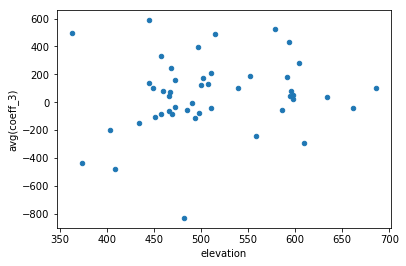

In [22]:
%matplotlib inline
pdf.plot.scatter(x='elevation',y='avg(coeff_3)');

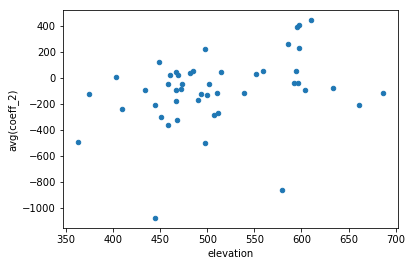

In [27]:
pdf.plot.scatter(x='elevation',y='avg(coeff_2)');

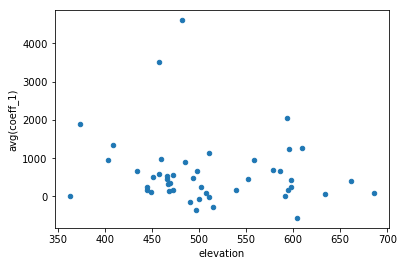

In [28]:
pdf.plot.scatter(x='elevation',y='avg(coeff_1)');

In [12]:
RDD1=sc.parallelize(["spark  basics", "spark big  data analysis", "spring"]) 
RDD2=sc.parallelize(["spark using pyspark", "big data"])
 
RDD1.subtract(RDD2).collect()

['spark big  data analysis', 'spring', 'spark  basics']

In [38]:
sc.stop()